In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import re

# --------------------------
# Table2: 洛杉矶CPI数据 (宽表转长表)
# --------------------------


# 读取Excel文件，跳过前11行元数据，确保正确获取列名和数据
cpi = pd.read_excel(
    "Table2_LA LB_CPI.xlsx",
    sheet_name="BLS Data Series",
    skiprows=11,        # 跳过前11行元数据
    header=0,          # 第12行作为列名（Year, Jan, Feb...）
    usecols="A:M"      # 直接选取前13列（Year + 12个月）
)

# 宽表转长表
cpi = cpi.melt(
    id_vars="Year",
    var_name="Month",
    value_name="CPI"
)

# 过滤非月份的行（如Annual/HALF等）
cpi = cpi[cpi["Month"].isin(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])]

# 将月份缩写映射为数字
month_map = {
    "Jan": "1", "Feb": "2", "Mar": "3", "Apr": "4",
    "May": "5", "Jun": "6", "Jul": "7", "Aug": "8",
    "Sep": "9", "Oct": "10", "Nov": "11", "Dec": "12"
}
cpi["Month"] = cpi["Month"].map(month_map)

# 合并年份和月份为日期，并排序
cpi["Date"] = pd.to_datetime(cpi["Year"].astype(str) + "-" + cpi["Month"])
cpi = cpi[["Date", "CPI"]].sort_values("Date").reset_index(drop=True)

# 输出结果
print(cpi.head())
print(cpi.tail())

# --------------------------
# Table3: 柴油价格 (直接读取日期列)
# --------------------------
# 直接读取并清理列名
diesel = pd.read_excel(
    "Table3_Diesel_Price(2004-2024).xlsx",
    parse_dates=['Date '],
    usecols=['Date ','Price (cents per gallon)']
).rename(columns={'Date ':'Date'})

# 无需重采样，直接使用原始日期
diesel_monthly = diesel.rename(columns={'Price (cents per gallon)':'Diesel Price (cents per gallon)'})

print(diesel_monthly.head())
print(diesel_monthly.tail())

# --------------------------
# Table4: 港口TEUs数据 (多sheet合并)
# --------------------------
def process_teus(file_path):
    
    month_map = {
        'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
        'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12
    }
    
    # 新增目标列映射（列名正则匹配规则）
    column_patterns = {
        'Loaded_Imports': r'loadedimports',
        'Empty_Imports': r'emptyimports',
        'Total_Imports': r'totalimports',
        'Loaded_Exports': r'loadedexports',
        'Empty_Exports': r'emptyexports',
        'Total_Exports': r'totalexports',
        'Total_TEUs': r'totalteus',
        'Prior_Year_Change':r'prioryearchange',
    }
    
    def clean_value(x):
        # 原清洗逻辑保持不变
        if isinstance(x, str):
            x_clean = re.sub(r'[^\w\s\.-]', '', x.strip().lower())
            x_clean = x_clean.replace('\xa0', '').replace(',', '')
            parts = x_clean.split('.')
            if len(parts) > 2:
                x_clean = f"{parts}.{''.join(parts[1:])}"
            if re.match(r'^-?\d+\.?\d*$', x_clean):
                return float(x_clean) if '.' in x_clean else int(x_clean)
            return x_clean
        return x
    
    teus_dfs = []
    
    sheets = pd.ExcelFile(file_path).sheet_names
    
    for sheet in sheets:
        if not sheet.isdigit() or not (2012 <= int(sheet) <= 2024):
            continue
            
        try:
            df_header = pd.read_excel(file_path, sheet_name=sheet, header=None, nrows=20)
            
            # 动态定位所有目标列的索引
            col_indices = {'Month_Col': None}
            for row_idx in range(15):
                current_row = df_header.iloc[row_idx].apply(clean_value)
                current_row_str = [str(c).lower().replace(' ', '') for c in current_row]
                
                # 定位月份列
                if col_indices['Month_Col'] is None:
                    for col_idx, val in enumerate(current_row):
                        if val in month_map:
                            col_indices['Month_Col'] = col_idx
                            break
                    if col_indices['Month_Col'] is None:
                        for col_idx, val in enumerate(current_row_str):
                            if 'month' in val:
                                col_indices['Month_Col'] = col_idx
                                break
                
                # 定位其他目标列
                for col_name, pattern in column_patterns.items():
                    if col_name not in col_indices or col_indices[col_name] is None:
                        for col_idx, val in enumerate(current_row_str):
                            if re.search(pattern, val):
                                col_indices[col_name] = col_idx
                                break
                
                # 检查是否所有列已定位
                if all(v is not None for v in col_indices.values()):
                    data_start = row_idx + 1
                    break
            else:
                continue  # 未找到所有列则跳过当前sheet
                
            # 读取目标列数据
            usecols = [col_indices['Month_Col']] + list(col_indices.values())[1:]
            df = pd.read_excel(
                file_path,
                sheet_name=sheet,
                header=None,
                skiprows=data_start,
                usecols=usecols,
                names=['Month'] + list(column_patterns.keys())
            )
            
            # 数据清洗
            df['Month'] = df['Month'].apply(clean_value).str.lower()
            df = df[df['Month'].isin(month_map)]
            for col in column_patterns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            
            df['Year'] = int(sheet)
            df['Month'] = df['Month'].map(month_map)
            df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
            
            teus_dfs.append(df[['Date'] + list(column_patterns.keys())])
            
        except Exception as e:
            print(f"处理 {sheet} 时错误: {str(e)}")
            continue
    
    teus = pd.concat(teus_dfs).sort_values('Date').reset_index(drop=True)
    return teus

# 执行
teus = process_teus("Table4_LA_Container_TEUs.xlsx")
print(teus.head())
print(teus.tail())


# --------------------------
# Table5: 运价指数NCFI (周转月)
# --------------------------
ncfi = pd.read_excel("Table5_美西运价指数NCFI(2014-2024).xlsx",
                    parse_dates=['Date'])
ncfi_monthly = ncfi.resample('MS', on='Date').mean().reset_index()
print(ncfi_monthly.head())
print(ncfi_monthly.tail())

# --------------------------
# Table1: 中国PMI (多sheet合并)
# --------------------------

def extract_pmi(file_path):
    # 读取Excel文件
    df = pd.read_excel(file_path, sheet_name='Sheet1')
    
    # 生成日期列（每月第一天）
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
    
    # 仅保留Date和PMI列
    result = df[['Date', 'PMI']].sort_values('Date').reset_index(drop=True)
    
    # 验证数据完整性
    expected = (2024 - 2014 + 1) * 12
    if len(result) != expected:
        print(f"警告: 缺失{expected - len(result)}个月份数据")
    else:
        print("所有数据完整")
    
    return result

# 执行处理
pmi_data = extract_pmi("Table1_只保留中国制造业PMI_月度数据(2014-2024).xlsx")

print("处理结果:")
print(pmi_data.head(3))
print("\n...中间数据省略...\n")
print(pmi_data.tail(3))
print(f"\n总数据量: {len(pmi_data)}条 (预期132条)")

# --------------------------
# Table6: 船舶活动数据 (完整数据处理)
# --------------------------
def process_vessel_activity(file_path):
    import pandas as pd
    from itertools import zip_longest

    # 合并单元格处理函数（优化版）
    def split_combined_rows(row):
        columns = []
        for cell in row:
            # 处理换行符和合并单元格
            if isinstance(cell, str) and '\n' in cell:
                parts = [c.strip() for c in cell.split('\n') if c.strip() != '']
            else:
                parts = [str(cell).strip()]
            columns.append(parts)
        
        # 找到最大列数
        max_len = max(len(col) for col in columns)
        # 填充缺失值
        return [
            [col[i] if i < len(col) else pd.NA for col in columns]
            for i in range(max_len)
        ]

    # 读取并处理原始数据（增加错误处理）
    try:
        raw_data = pd.read_excel(
            file_path, 
            header=None, 
            skiprows=1,
            engine='openpyxl'  # 明确指定引擎防止警告
        ).values.tolist()
    except Exception as e:
        print(f"文件读取失败: {str(e)}")
        return pd.DataFrame()

    processed_data = []
    for row in raw_data:
        processed_data.extend(split_combined_rows(row))

    # 创建DataFrame
    vessel = pd.DataFrame(
        processed_data,
        columns=['Date', 'POLA Vessels at Anchor', 'POLA Vessels at Berth',
                'POLA Vessels Departed', 'Average Days at Berth', 
                'Average Days at ANC + Berth']
    )

    # ---- 修正：灵活日期解析 ----
    def safe_date_parse(date_str):
        try:
            # 尝试多种日期格式
            for fmt in ('%m/%d/%Y', '%d/%m/%Y', '%Y-%m-%d'):
                try:
                    return pd.to_datetime(date_str, format=fmt, exact=False)
                except:
                    continue
            return pd.NaT
        except:
            return pd.NaT

    vessel['Date'] = vessel['Date'].apply(safe_date_parse)
    
    # 过滤无效日期和范围
    vessel = vessel[vessel['Date'].dt.year >= 2015]
    vessel = vessel.dropna(subset=['Date'])
    
    # 数值类型转换（增加异常处理）
    numeric_cols = ['POLA Vessels at Anchor', 'POLA Vessels at Berth',
                   'POLA Vessels Departed', 'Average Days at Berth',
                   'Average Days at ANC + Berth']
    
    for col in numeric_cols:
        vessel[col] = pd.to_numeric(vessel[col], errors='coerce')
    
    # 月度聚合（保留原始日期格式）
    vessel_monthly = (
        vessel.resample('MS', on='Date')
        .agg({
            'POLA Vessels at Anchor': 'mean',
            'POLA Vessels at Berth': 'mean',
            'POLA Vessels Departed': 'sum',
            'Average Days at Berth': 'mean',
            'Average Days at ANC + Berth': 'mean'
        })
        .reset_index()
        .round(2)
    )
    
    return vessel_monthly

# 执行并验证
vessel_monthly = process_vessel_activity("Table6_LA_Vessel_Activity.xlsx")
print("修正后的船舶数据日期范围:", vessel_monthly['Date'].min(), "至", vessel_monthly['Date'].max())
print(vessel_monthly.head(3))
print(vessel_monthly.tail(3))

        Date    CPI
0 2004-01-01  188.5
1 2004-02-01  190.1
2 2004-03-01  191.5
3 2004-04-01  191.9
4 2004-05-01  193.3
          Date      CPI
247 2024-08-01  333.359
248 2024-09-01  334.123
249 2024-10-01  334.242
250 2024-11-01  333.718
251 2024-12-01  334.531
        Date  Diesel Price (cents per gallon)
0 2004-01-01                            155.1
1 2004-02-01                            158.2
2 2004-03-01                            162.9
3 2004-04-01                            169.2
4 2004-05-01                            174.6
          Date  Diesel Price (cents per gallon)
247 2024-08-01                            370.0
248 2024-09-01                            355.8
249 2024-10-01                            358.5
250 2024-11-01                            352.2
251 2024-12-01                            349.4
        Date  Loaded_Imports  Empty_Imports  Total_Imports  Loaded_Exports  \
0 2012-02-01       254359.60        9099.20      263458.80       164725.25   
1 2012-03-01    

In [2]:
def check_date_range(df, name):
    print(f"{name} 时间范围: {df['Date'].min()} 至 {df['Date'].max()}")

check_date_range(cpi, "CPI")
check_date_range(diesel_monthly, "柴油价格")
check_date_range(teus, "TEUs")
check_date_range(ncfi_monthly, "NCFI")
check_date_range(pmi_data, "PMI")
check_date_range(vessel_monthly, "船舶活动")

CPI 时间范围: 2004-01-01 00:00:00 至 2024-12-01 00:00:00
柴油价格 时间范围: 2004-01-01 00:00:00 至 2024-12-01 00:00:00
TEUs 时间范围: 2012-02-01 00:00:00 至 2024-12-01 00:00:00
NCFI 时间范围: 2014-01-01 00:00:00 至 2024-12-01 00:00:00
PMI 时间范围: 2014-01-01 00:00:00 至 2024-12-01 00:00:00
船舶活动 时间范围: 2015-03-01 00:00:00 至 2024-12-01 00:00:00


In [3]:
# 获取船舶数据的起始和结束日期
start_date = vessel_monthly['Date'].min()
end_date = vessel_monthly['Date'].max()

# 将所有数据集截断到船舶数据的时间范围内
ncfi_monthly = ncfi_monthly[(ncfi_monthly['Date'] >= start_date) & (ncfi_monthly['Date'] <= end_date)]
cpi = cpi[(cpi['Date'] >= start_date) & (cpi['Date'] <= end_date)]
diesel_monthly = diesel_monthly[(diesel_monthly['Date'] >= start_date) & (diesel_monthly['Date'] <= end_date)]
teus = teus[(teus['Date'] >= start_date) & (teus['Date'] <= end_date)]
pmi_data = pmi_data[(pmi_data['Date'] >= start_date) & (pmi_data['Date'] <= end_date)]

# 验证截断后的时间范围
print("船舶数据时间范围:", start_date, "至", end_date)
print("NCFI截断后时间范围:", ncfi_monthly['Date'].min(), "至", ncfi_monthly['Date'].max())

船舶数据时间范围: 2015-03-01 00:00:00 至 2024-12-01 00:00:00
NCFI截断后时间范围: 2015-03-01 00:00:00 至 2024-12-01 00:00:00


In [4]:
# 确保所有数据集日期类型统一为datetime
datasets = {
    'cpi': cpi,
    'diesel': diesel_monthly,
    'teus': teus,
    'ncfi': ncfi_monthly,
    'pmi': pmi_data,
    'vessel': vessel_monthly
}

for name, df in datasets.items():
    df['Date'] = pd.to_datetime(df['Date'])
    print(f"{name} 日期类型已统一为:", df['Date'].dtype)

# 合并所有数据（左连接，以NCFI为基准）
merged_data = ncfi_monthly.merge(cpi, on='Date', how='left') \
                          .merge(diesel_monthly, on='Date', how='left') \
                          .merge(teus, on='Date', how='left') \
                          .merge(pmi_data, on='Date', how='left') \
                          .merge(vessel_monthly, on='Date', how='left')

# 检查缺失值分布
print("\n缺失值统计:")
print(merged_data.isnull().sum())
# 线性插值填充缺失值（保留时间序列连续性）
merged_data = merged_data.interpolate(method='linear', limit_direction='both')
# 删除残留缺失值（可选）
merged_data = merged_data.dropna()

# 显示合并后的列名和日期范围
print("\n合并后的列:", merged_data.columns.tolist())
print("最终日期范围:", merged_data['Date'].min(), "至", merged_data['Date'].max())

cpi 日期类型已统一为: datetime64[ns]
diesel 日期类型已统一为: datetime64[ns]
teus 日期类型已统一为: datetime64[ns]
ncfi 日期类型已统一为: datetime64[ns]
pmi 日期类型已统一为: datetime64[ns]
vessel 日期类型已统一为: datetime64[ns]

缺失值统计:
Date                                                      0
Ningbo Containerized Freight Index, NCFI (West Coast)     0
CPI                                                       0
Diesel Price (cents per gallon)                           0
Loaded_Imports                                           10
Empty_Imports                                            12
Total_Imports                                            13
Loaded_Exports                                           15
Empty_Exports                                            16
Total_Exports                                            12
Total_TEUs                                               13
Prior_Year_Change                                        11
PMI                                                       0
POLA Vessels at Anchor        

In [5]:
# 查看各列数据类型
print("合并后数据各列数据类型:\n", merged_data.dtypes)

合并后数据各列数据类型:
 Date                                                     datetime64[ns]
Ningbo Containerized Freight Index, NCFI (West Coast)           float64
CPI                                                             float64
Diesel Price (cents per gallon)                                 float64
Loaded_Imports                                                  float64
Empty_Imports                                                   float64
Total_Imports                                                   float64
Loaded_Exports                                                  float64
Empty_Exports                                                   float64
Total_Exports                                                   float64
Total_TEUs                                                      float64
Prior_Year_Change                                               float64
PMI                                                             float64
POLA Vessels at Anchor                            

In [6]:
print("合并后数据时间范围:", merged_data['Date'].min(), "至", merged_data['Date'].max())

合并后数据时间范围: 2015-03-01 00:00:00 至 2024-12-01 00:00:00


In [7]:
# 添加时间相关特征
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Quarter'] = merged_data['Date'].dt.quarter

# 构建滞后特征（过去3个月的运价指数）
target = 'Ningbo Containerized Freight Index, NCFI (West Coast)'
for lag in [1, 2, 3]:
    merged_data[f'NCFI_lag{lag}'] = merged_data[target].shift(lag)

# 删除因滞后产生的缺失值
merged_data = merged_data.dropna()

# 查看最终特征列
print("最终特征列:", merged_data.columns.tolist())

最终特征列: ['Date', 'Ningbo Containerized Freight Index, NCFI (West Coast)', 'CPI', 'Diesel Price (cents per gallon)', 'Loaded_Imports', 'Empty_Imports', 'Total_Imports', 'Loaded_Exports', 'Empty_Exports', 'Total_Exports', 'Total_TEUs', 'Prior_Year_Change', 'PMI', 'POLA Vessels at Anchor', 'POLA Vessels at Berth', 'POLA Vessels Departed', 'Average Days at Berth', 'Average Days at ANC + Berth', 'Month', 'Quarter', 'NCFI_lag1', 'NCFI_lag2', 'NCFI_lag3']


In [8]:
print("添加时间特征后数据时间范围:", merged_data['Date'].min(), "至", merged_data['Date'].max())

添加时间特征后数据时间范围: 2015-06-01 00:00:00 至 2024-12-01 00:00:00


In [9]:
# 检查NaN
print("NaN统计:\n", merged_data.isnull().sum())

# 检查Inf（仅对数值列操作）
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns.tolist()
inf_check = np.isinf(merged_data[numeric_cols].values)
print("\n无穷值统计:", np.any(inf_check))

NaN统计:
 Date                                                     0
Ningbo Containerized Freight Index, NCFI (West Coast)    0
CPI                                                      0
Diesel Price (cents per gallon)                          0
Loaded_Imports                                           0
Empty_Imports                                            0
Total_Imports                                            0
Loaded_Exports                                           0
Empty_Exports                                            0
Total_Exports                                            0
Total_TEUs                                               0
Prior_Year_Change                                        0
PMI                                                      0
POLA Vessels at Anchor                                   0
POLA Vessels at Berth                                    0
POLA Vessels Departed                                    0
Average Days at Berth                           

In [10]:
print(merged_data.head())

        Date  Ningbo Containerized Freight Index, NCFI (West Coast)      CPI  \
3 2015-06-01                                           838.3525      245.459   
4 2015-07-01                                           752.4660      247.066   
5 2015-08-01                                           673.0525      246.328   
6 2015-09-01                                           814.7375      245.431   
7 2015-10-01                                           761.4960      245.812   

   Diesel Price (cents per gallon)  Loaded_Imports  Empty_Imports  \
3                            287.3       368708.50        9072.10   
4                            278.8       350627.85       11374.10   
5                            259.5       407804.40        9514.40   
6                            250.5       372991.50       10971.90   
7                            251.9       358601.50       13814.15   

   Total_Imports  Loaded_Exports  Empty_Exports  Total_Exports  ...  \
3      377780.60       143549.25 

In [11]:
merged_data.to_csv("merged_data_cleaned_final.csv", index=False)
print("\n数据已保存为 merged_data_cleaned_final.csv")


数据已保存为 merged_data_cleaned_final.csv


In [12]:
# 确认Date列是datetime类型
print("Date列数据类型:", merged_data['Date'].dtype)

# 如果不是datetime类型，强制转换
if not pd.api.types.is_datetime64_any_dtype(merged_data['Date']):
    merged_data['Date'] = pd.to_datetime(merged_data['Date'])
    print("已将Date列转换为datetime类型")

Date列数据类型: datetime64[ns]


线性回归（作为基准）

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 分离特征与目标变量
target = 'Ningbo Containerized Freight Index, NCFI (West Coast)'
features = merged_data.drop(columns=[target, 'Date'])
y = merged_data[target]

# 标准化特征（保留列名）
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# 按时间顺序划分训练集和测试集（80%训练，20%测试）
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled.iloc[:split_idx], X_scaled.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"训练集时间范围: {merged_data['Date'].iloc[0]} 至 {merged_data['Date'].iloc[split_idx-1]}")
print(f"测试集时间范围: {merged_data['Date'].iloc[split_idx]} 至 {merged_data['Date'].iloc[-1]}")

训练集时间范围: 2015-06-01 00:00:00 至 2023-01-01 00:00:00
测试集时间范围: 2023-02-01 00:00:00 至 2024-12-01 00:00:00


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 初始化模型
lr_model = LinearRegression()

# 训练模型
lr_model.fit(X_train, y_train)

# 预测测试集
y_pred_lr = lr_model.predict(X_test)

# 计算指标（兼容所有版本）
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)  # 手动计算RMSE
r2_lr = r2_score(y_test, y_pred_lr)

# 输出结果
print(f"线性回归模型性能:\nRMSE = {rmse_lr:.2f}\nR² = {r2_lr:.2f}")

# 输出关键特征系数
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(5)

print("\nTop 5重要特征系数:")
print(coef_df)

线性回归模型性能:
RMSE = 290.90
R² = 0.81

Top 5重要特征系数:
                        Feature  Coefficient
18                    NCFI_lag1  1592.119140
19                    NCFI_lag2  -473.815910
8                    Total_TEUs   198.365676
15  Average Days at ANC + Berth   198.309419
16                        Month  -192.277967


In [15]:
import torch
import torch.nn as nn

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test.values)

# 定义线性回归模型
class PyTorchLinearRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # 输入特征数应为整数（使用shape获取特征数量）
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# 获取输入特征数
print(X_train.shape) # 得到(样本数, 特征数)
input_size = 21 # 特征数
model = PyTorchLinearRegression(input_size=input_size)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 训练模型
epochs = 5000
for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 预测测试集
with torch.no_grad():
    y_pred_torch = model(X_test_tensor).numpy().flatten()

# 计算评估指标
rmse_torch = np.sqrt(mean_squared_error(y_test, y_pred_torch))
r2_torch = r2_score(y_test, y_pred_torch)

print(f"PyTorch线性回归性能:\nRMSE = {rmse_torch:.2f}\nR² = {r2_torch:.2f}")

(92, 21)
PyTorch线性回归性能:
RMSE = 330.84
R² = 0.75


可以看到pytorch和sklearn得到的线性回归结果还是比较接近的

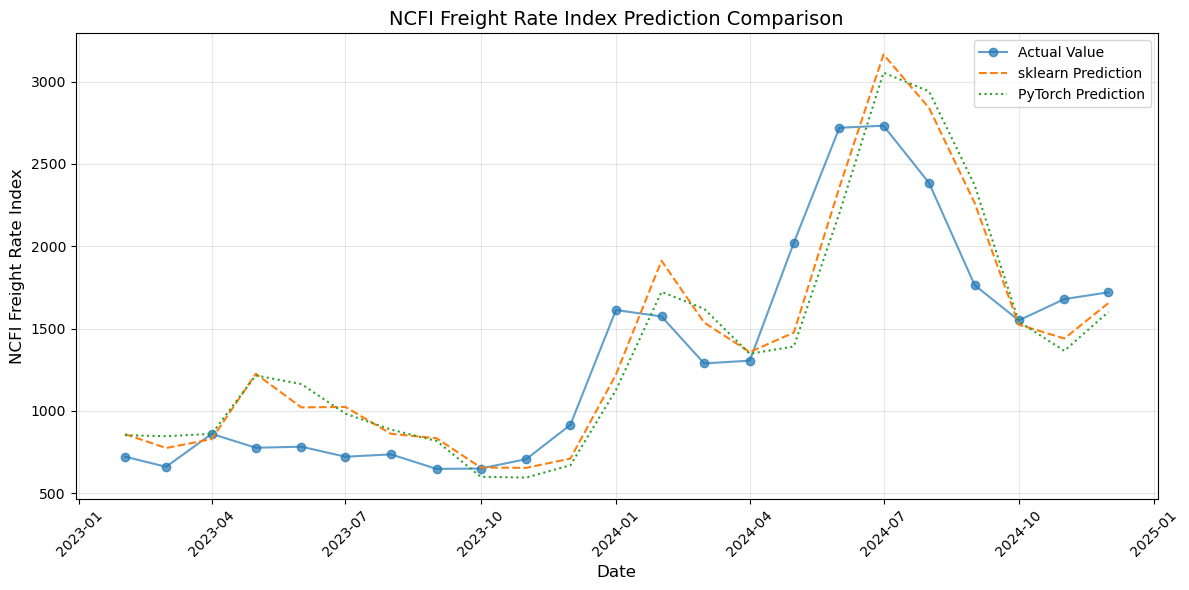

In [16]:
import matplotlib.pyplot as plt

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'].iloc[split_idx:], y_test, label='Actual Value', marker='o', alpha=0.7)
plt.plot(merged_data['Date'].iloc[split_idx:], y_pred_lr, label='sklearn Prediction', linestyle='--')
plt.plot(merged_data['Date'].iloc[split_idx:], y_pred_torch, label='PyTorch Prediction', linestyle=':')
plt.title('NCFI Freight Rate Index Prediction Comparison', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('NCFI Freight Rate Index', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

移动平均

In [17]:
# 创建移动平均特征
merged_data['NCFI_MA3'] = (
    merged_data['Ningbo Containerized Freight Index, NCFI (West Coast)']
    .rolling(window=3, min_periods=1)
    .mean()
)

merged_data['NCFI_MA12'] = (
    merged_data['Ningbo Containerized Freight Index, NCFI (West Coast)']
    .rolling(window=12, min_periods=1)
    .mean()
)

# 前向填充初始缺失值
merged_data[['NCFI_MA3',
            'NCFI_MA12']] = (
    merged_data[['NCFI_MA3',
                'NCFI_MA12']]
    .fillna(method='ffill')
)

C:\Users\Michael Jordan\AppData\Local\Temp\ipykernel_9816\2349717137.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')


季节性分解

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# 确保日期索引正确
merged_data = merged_data.set_index('Date').sort_index()


stl = STL(
    merged_data['Ningbo Containerized Freight Index, NCFI (West Coast)'],
    period=12,
    seasonal=13,  # 略大于12以适应动态变化
    robust=True   # 抗异常值
)
result_stl = stl.fit()

# 合并结果并验证
merged_data['trend_stl'] = result_stl.trend
merged_data['seasonal_stl'] = result_stl.seasonal
merged_data['residual_stl'] = result_stl.resid

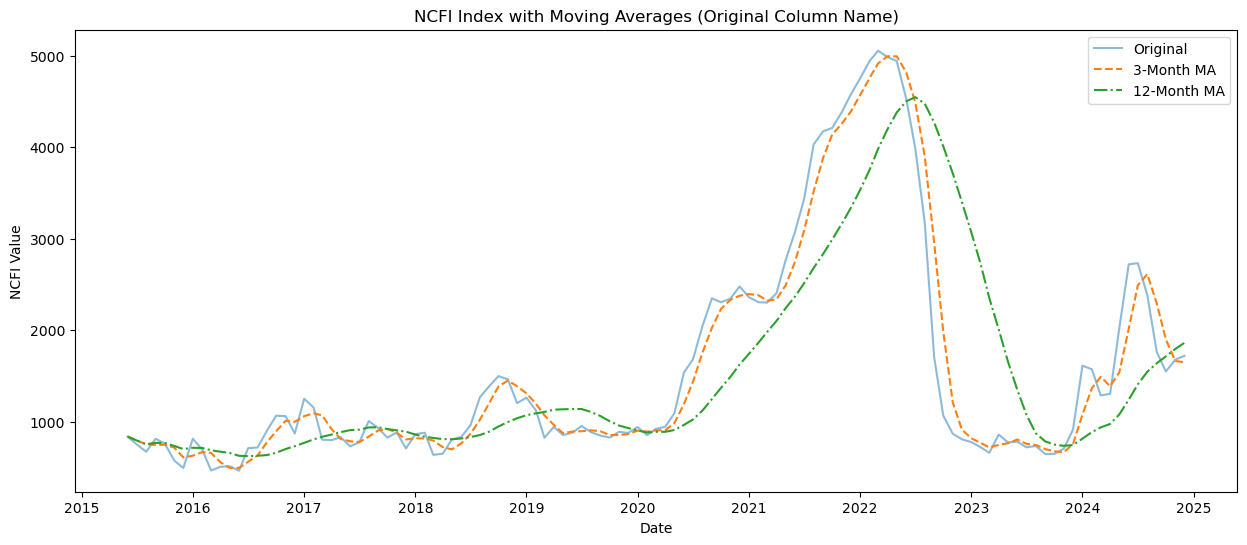

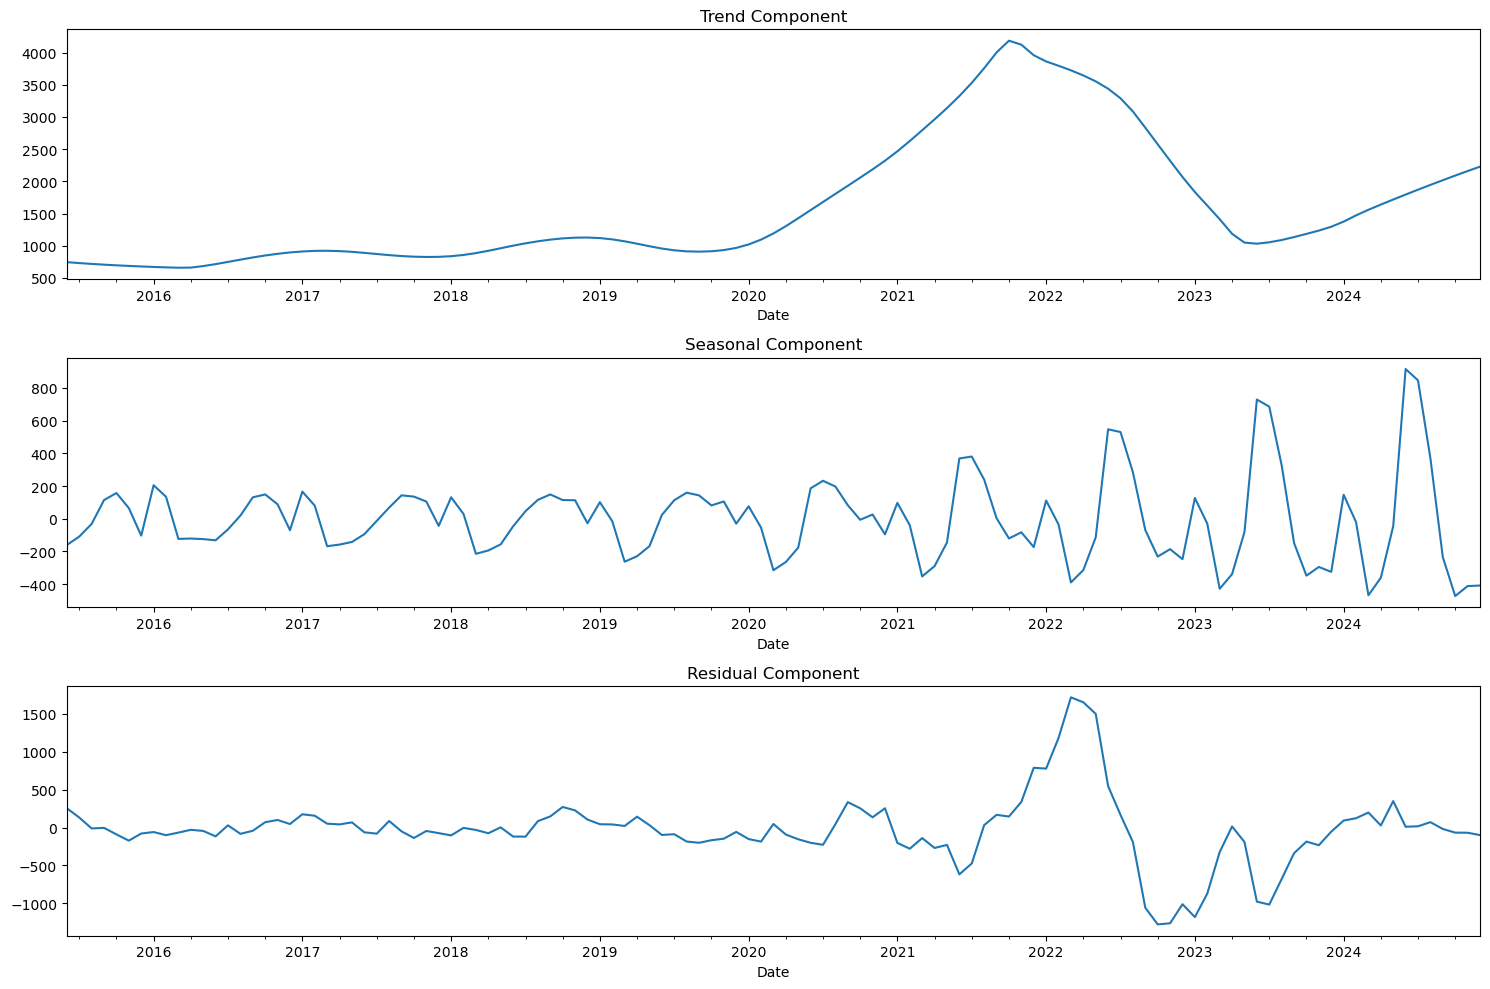

In [19]:
import matplotlib.pyplot as plt

# 移动平均可视化
plt.figure(figsize=(15,6))
plt.plot(
    merged_data.index,
    merged_data['Ningbo Containerized Freight Index, NCFI (West Coast)'],
    label='Original',
    alpha=0.5
)
plt.plot(
    merged_data.index,
    merged_data['NCFI_MA3'],
    label='3-Month MA',
    linestyle='--'
)
plt.plot(
    merged_data.index,
    merged_data['NCFI_MA12'],
    label='12-Month MA',
    linestyle='-.'
)
plt.title('NCFI Index with Moving Averages (Original Column Name)')
plt.xlabel('Date')
plt.ylabel('NCFI Value')
plt.legend()
plt.show()

# 季节性分解可视化
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
merged_data['trend_stl'].plot(ax=ax1, title='Trend Component')
merged_data['seasonal_stl'].plot(ax=ax2, title='Seasonal Component')
merged_data['residual_stl'].plot(ax=ax3, title='Residual Component')
plt.tight_layout()

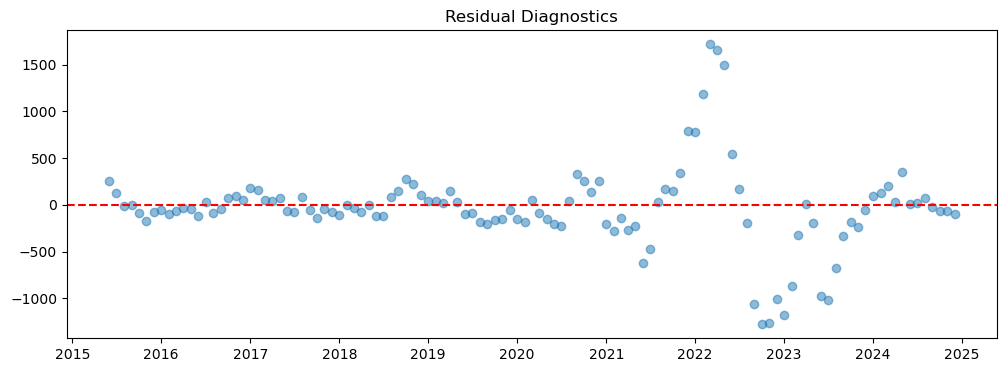

In [20]:
# 残差诊断
plt.figure(figsize=(12,4))
plt.scatter(
    merged_data.index,
    merged_data['residual_stl'],
    alpha=0.5
)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Diagnostics')
plt.show()

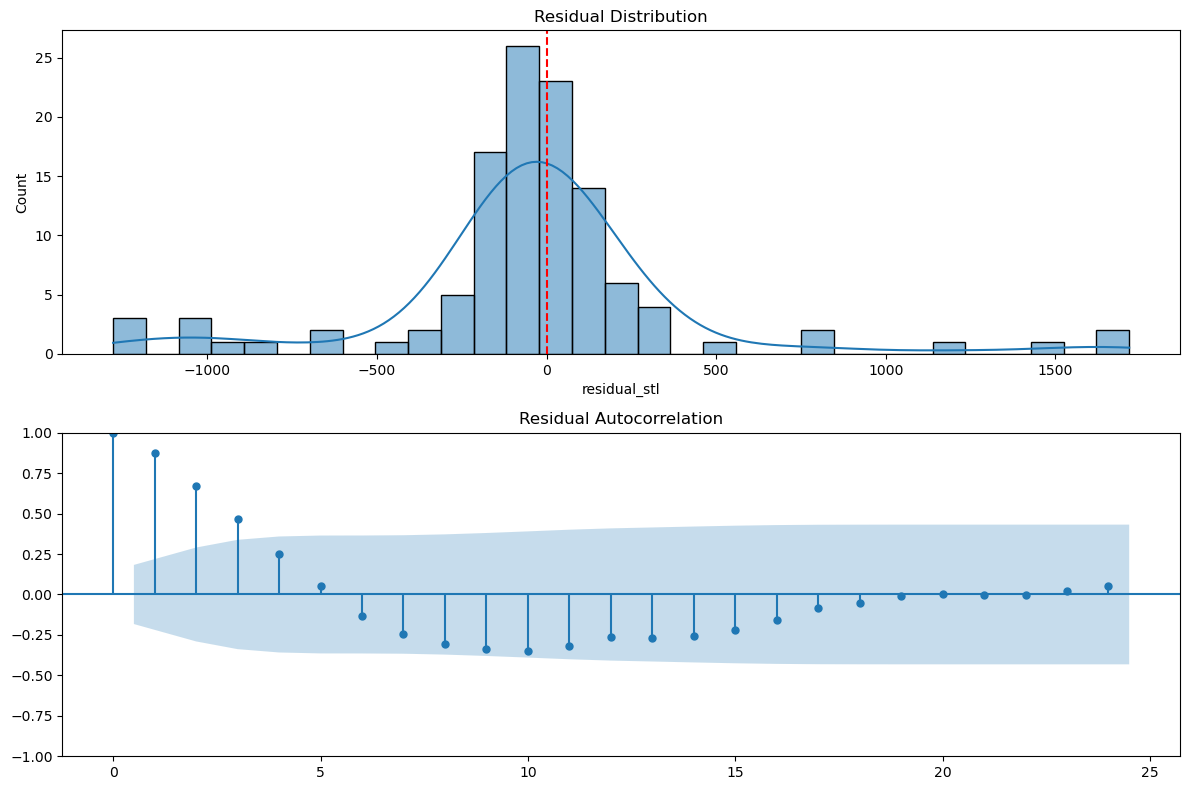

In [21]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# 绘制残差分布与自相关图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# 残差分布
sns.histplot(merged_data['residual_stl'], kde=True, ax=ax1)
ax1.axvline(0, color='r', linestyle='--')
ax1.set_title('Residual Distribution')

# 残差自相关图（ACF）
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(merged_data['residual_stl'].dropna(), lags=24, ax=ax2)
ax2.set_title('Residual Autocorrelation')

plt.tight_layout()
plt.show()

残差近似正态分布，没问题，只是自相关图似乎有一定的规律。

In [22]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# 生成完整节假日列表
cal = USFederalHolidayCalendar()
holidays = cal.holidays(
    start=merged_data.index.min(),  # 数据集起始日期
    end=merged_data.index.max(),    # 数据集结束日期
    return_name=True                # 返回节日名称
)

print("生成的联邦节假日数量:", len(holidays))
print("节假日样例:\n", holidays.head(10))

生成的联邦节假日数量: 99
节假日样例:
 2015-07-03                       Independence Day
2015-09-07                              Labor Day
2015-10-12                           Columbus Day
2015-11-11                           Veterans Day
2015-11-26                       Thanksgiving Day
2015-12-25                          Christmas Day
2016-01-01                         New Year's Day
2016-01-18    Birthday of Martin Luther King, Jr.
2016-02-15                  Washington's Birthday
2016-05-30                           Memorial Day
dtype: object


In [23]:
# 验证数据日期范围
print("数据日期范围:", merged_data.index.min(), "至", merged_data.index.max())

# 验证节假日日期范围
print("节假日日期范围:", holidays.index.min(), "至", holidays.index.max())

数据日期范围: 2015-06-01 00:00:00 至 2024-12-01 00:00:00
节假日日期范围: 2015-07-03 00:00:00 至 2024-11-28 00:00:00


In [24]:
# 生成所有联邦节假日并转换到月度起始日期
from pandas.tseries.holiday import USFederalHolidayCalendar

# 生成原始节假日日期
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015-01-01', end='2024-12-31')

# 将节假日转换到对应月份的起始日（如2020-07-04 → 2020-07-01）
holidays_monthly = pd.to_datetime(holidays).to_period('M').start_time

# 创建月度节假日标记
merged_data['Federal_Holiday'] = (
    merged_data.index.to_period('M').start_time
    .isin(holidays_monthly)
    .astype(int)
)

C:\Users\Michael Jordan\AppData\Local\Temp\ipykernel_9816\3433643612.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  merged_data['Federal_Holiday'].resample('Y').sum().plot(kind='bar')


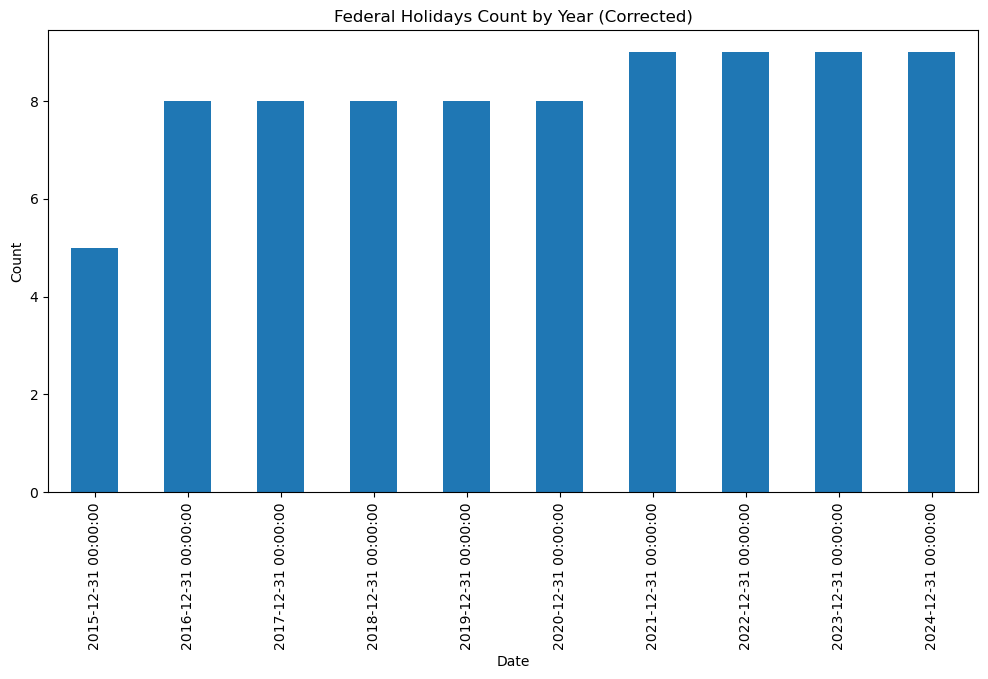

In [25]:
# 绘制年度节假日数量
plt.figure(figsize=(12,6))
merged_data['Federal_Holiday'].resample('Y').sum().plot(kind='bar')
plt.title('Federal Holidays Count by Year (Corrected)')
plt.ylabel('Count')
plt.show()

In [26]:
# 检查2020年节假日标记
print("2020年节假日月度标记:\n", merged_data.loc['2020', 'Federal_Holiday'].value_counts())

# 查看具体标记的月份
print("2020年标记为节假日的月份:")
print(merged_data.loc[merged_data['Federal_Holiday'] == 1].index.intersection(pd.date_range('2020-01-01', '2020-12-31')))

2020年节假日月度标记:
 Federal_Holiday
1    8
0    4
Name: count, dtype: int64
2020年标记为节假日的月份:
DatetimeIndex(['2020-01-01', '2020-02-01', '2020-05-01', '2020-07-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq=None)


随机森林

In [27]:
# 确认最终特征集
features = [
    'NCFI_lag1', 'NCFI_lag2', 'NCFI_lag3',
    'NCFI_MA3','NCFI_MA12',
    'Empty_Exports', 'Federal_Holiday',
    'Diesel Price (cents per gallon)', 'PMI', 
    'POLA Vessels at Anchor', 
    'Average Days at Berth', 'Average Days at ANC + Berth','Month',
    'POLA Vessels at Berth' , 'trend_stl','seasonal_stl',
]

# 检查特征缺失值
print("特征缺失值统计:")
print(merged_data[features].isnull().sum())

# 前向填充处理（时间序列适用）
merged_data[features] = merged_data[features].fillna(method='ffill')

特征缺失值统计:
NCFI_lag1                          0
NCFI_lag2                          0
NCFI_lag3                          0
NCFI_MA3                           0
NCFI_MA12                          0
Empty_Exports                      0
Federal_Holiday                    0
Diesel Price (cents per gallon)    0
PMI                                0
POLA Vessels at Anchor             0
Average Days at Berth              0
Average Days at ANC + Berth        0
Month                              0
POLA Vessels at Berth              0
trend_stl                          0
seasonal_stl                       0
dtype: int64


C:\Users\Michael Jordan\AppData\Local\Temp\ipykernel_9816\1182741554.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[features] = merged_data[features].fillna(method='ffill')


C:\Users\Michael Jordan\AppData\Local\Temp\ipykernel_9816\869799139.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[features] = merged_data[features].fillna(method='ffill')


Fold 1 RMSE: 290.60
Fold 2 RMSE: 100.76
Fold 3 RMSE: 293.86
Fold 4 RMSE: 119.10
Fold 5 RMSE: 567.67
Fold 6 RMSE: 844.69
Fold 7 RMSE: 1335.01
Fold 8 RMSE: 1413.96
Fold 9 RMSE: 261.99
Fold 10 RMSE: 442.21

平均RMSE: 566.98 ± 454.08


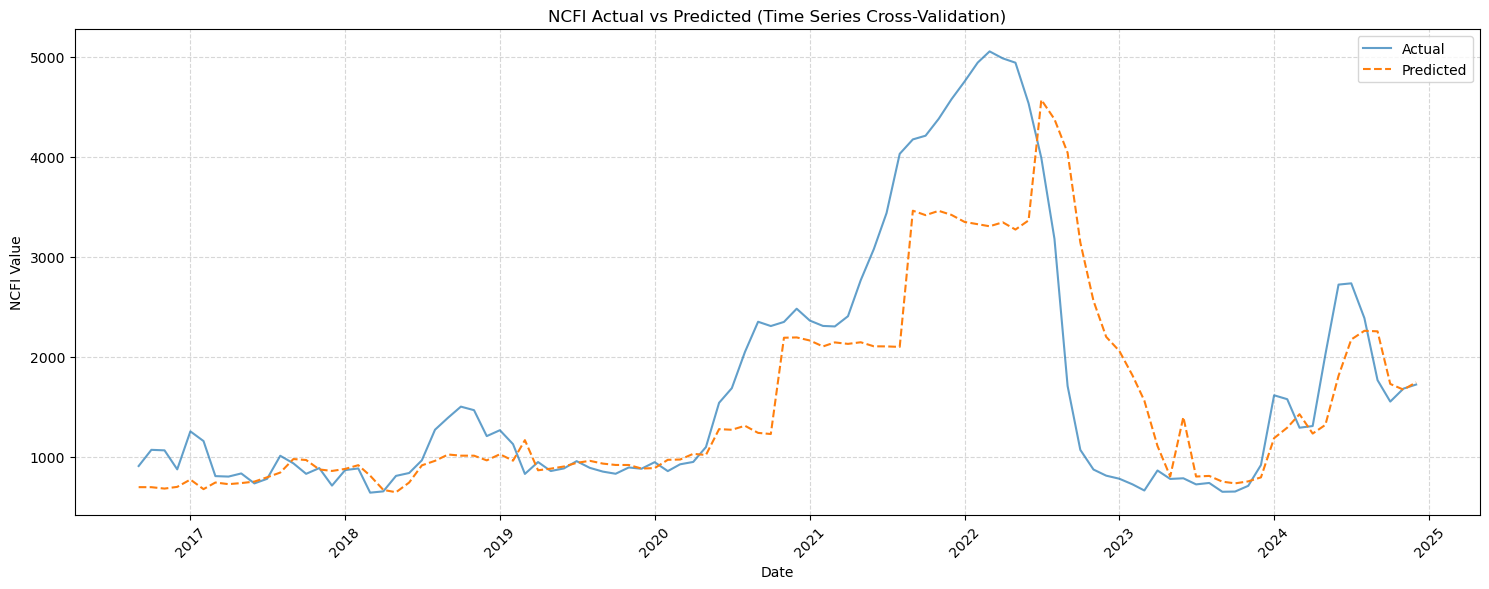

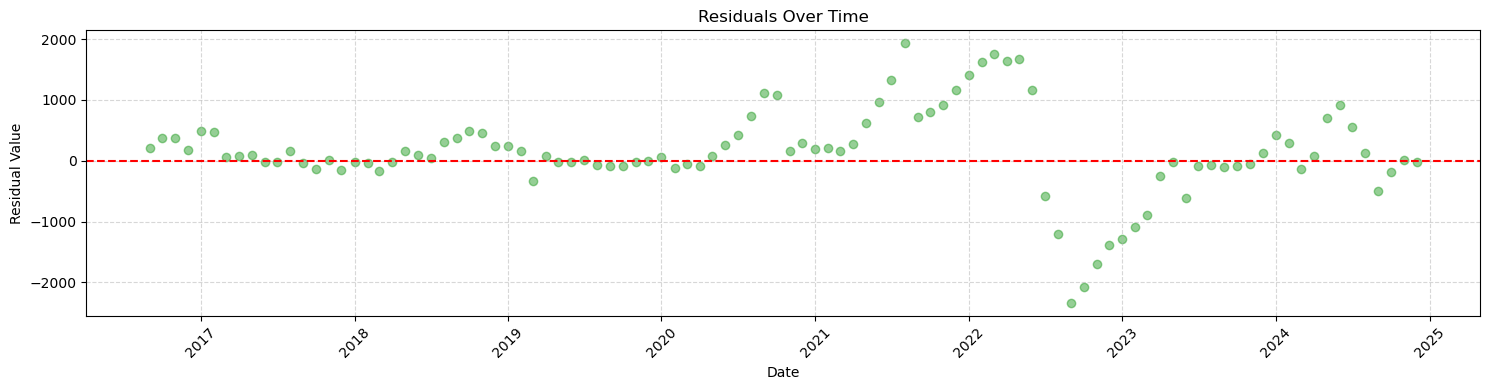

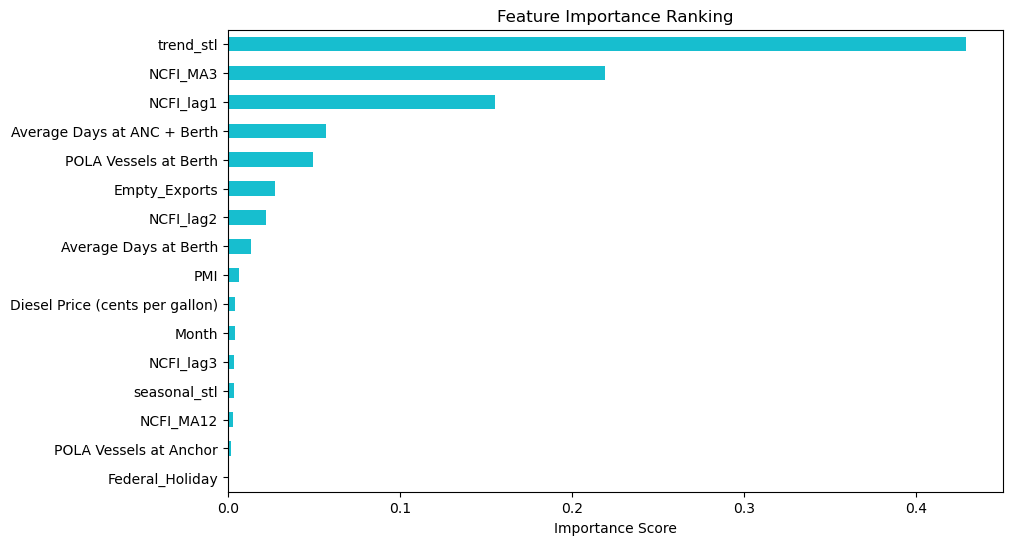

In [28]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# 定义特征和目标列
target_col = 'Ningbo Containerized Freight Index, NCFI (West Coast)'
features = [
    'NCFI_lag1', 'NCFI_lag2', 'NCFI_lag3',
    'NCFI_MA3','NCFI_MA12',
    'Empty_Exports', 'Federal_Holiday',
    'Diesel Price (cents per gallon)', 'PMI', 
    'POLA Vessels at Anchor', 
    'Average Days at Berth', 'Average Days at ANC + Berth','Month',
    'POLA Vessels at Berth' , 'trend_stl','seasonal_stl',
]

# 数据预处理（填充缺失值）
merged_data[features] = merged_data[features].fillna(method='ffill')

# 时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=10) # 分成10折
rmse_scores = []
all_preds = []
all_actuals = []
dates = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(merged_data)):
    # 数据划分
    X_train = merged_data.iloc[train_idx][features]
    y_train = merged_data.iloc[train_idx][target_col]
    X_test = merged_data.iloc[test_idx][features]
    y_test = merged_data.iloc[test_idx][target_col]
    
    # 模型训练
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=16,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # 预测与评估
    y_pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # 存储结果
    rmse_scores.append(rmse)
    all_preds.extend(y_pred)
    all_actuals.extend(y_test.values)
    dates.extend(merged_data.iloc[test_idx].index)
    print(f'Fold {fold+1} RMSE: {rmse:.2f}')

# 模型性能汇总
print(f"\n平均RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")

# 可视化预测对比
plt.figure(figsize=(15,6))
plt.plot(dates, all_actuals, label='Actual', alpha=0.7, color='#1f77b4')
plt.plot(dates, all_preds, label='Predicted', linestyle='--', color='#ff7f0e')
plt.title('NCFI Actual vs Predicted (Time Series Cross-Validation)')
plt.xlabel('Date')
plt.ylabel('NCFI Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 残差分析
residuals = np.array(all_actuals) - np.array(all_preds)
plt.figure(figsize=(15,4))
plt.scatter(dates, residuals, alpha=0.5, color='#2ca02c')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 特征重要性分析
importances = pd.Series(rf.feature_importances_, index=features)
plt.figure(figsize=(10,6))
importances.sort_values().plot(kind='barh', color='#17becf')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance Score')
plt.show()

RMSE不稳定.
<p>而且普通节假日在这里好像没什么影响，可能手动标注一下重要事件时间点会好一些。
<p>也许是因为没有归一化，在随机森林影响不是太大才对。
<p>预测2022时明显学习了2021的行为模式，结果较差。

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1278.101, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1233.128, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1241.928, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1276.101, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1240.108, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1234.060, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1230.184, Time=0.11 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1231.377, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1280.041, Time=0.03 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=1232.079, Time=0.14 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1232.027, Time=0.16 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept

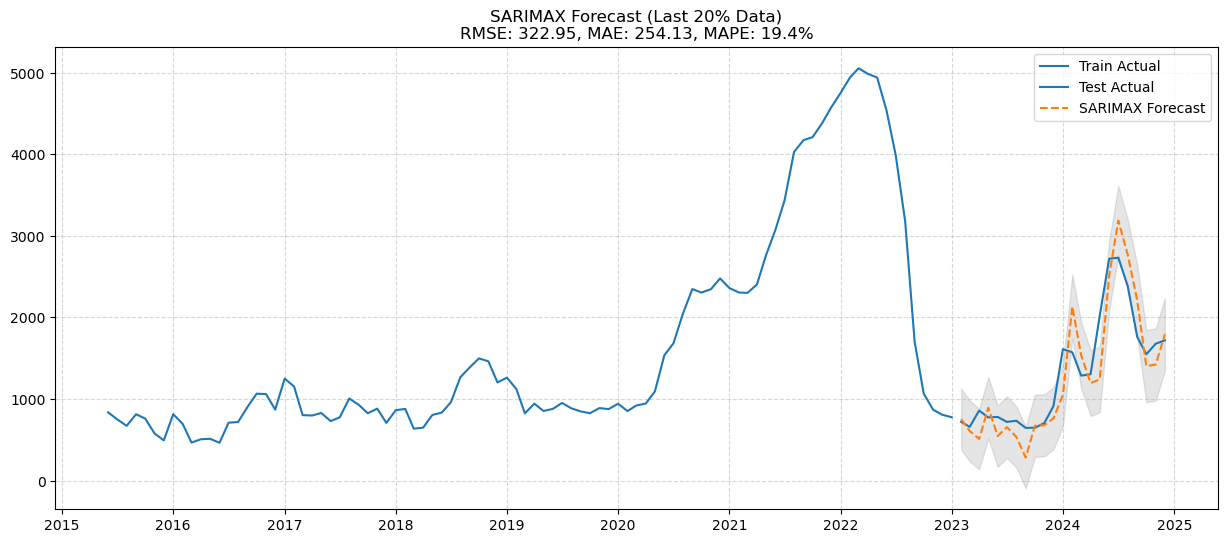

                                                 SARIMAX Results                                                 
Dep. Variable:     Ningbo Containerized Freight Index, NCFI (West Coast)   No. Observations:                   92
Model:                                  SARIMAX(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -525.964
Date:                                                   Fri, 14 Mar 2025   AIC                           1061.929
Time:                                                           16:02:56   BIC                           1073.713
Sample:                                                       06-01-2015   HQIC                          1066.646
                                                            - 01-01-2023                                         
Covariance Type:                                                     opg                                         
                                      coef    std err          z      P>|z|      [0.025 

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# 配置参数
test_size = 0.2
n_obs = len(merged_data)
split_point = int(n_obs * (1 - test_size))

# 分割数据集
train = merged_data['Ningbo Containerized Freight Index, NCFI (West Coast)'].iloc[:split_point]
test = merged_data['Ningbo Containerized Freight Index, NCFI (West Coast)'].iloc[split_point:]
exog_train = merged_data[['Diesel Price (cents per gallon)', 'POLA Vessels at Anchor']].iloc[:split_point]
exog_test = merged_data[['Diesel Price (cents per gallon)', 'POLA Vessels at Anchor']].iloc[split_point:]

# 自动参数调优
from pmdarima import auto_arima
model = auto_arima(
    train,
    exogenous=exog_train,
    seasonal=True, m=12,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
optimized_order = model.order
optimized_seasonal_order = model.seasonal_order

# 训练SARIMAX模型
sarimax_model = sm.tsa.SARIMAX(
    train,
    exog=exog_train,
    order=optimized_order,
    seasonal_order=optimized_seasonal_order,
    enforce_stationarity=False
)
sarimax_result = sarimax_model.fit(disp=False)

# 动态滚动预测
forecasts, lower_bounds, upper_bounds = [], [], []
current_end = split_point - 1
for t in range(len(test)):
    # 扩展训练集
    model = sm.tsa.SARIMAX(
        merged_data.iloc[:current_end+1]['Ningbo Containerized Freight Index, NCFI (West Coast)'],
        exog=merged_data.iloc[:current_end+1][['Diesel Price (cents per gallon)', 'POLA Vessels at Anchor']],
        order=optimized_order,
        seasonal_order=optimized_seasonal_order
    )
    result = model.fit(disp=False)
    
    # 单步预测
    forecast = result.get_forecast(
        steps=1,
        exog=merged_data.iloc[[current_end+1]][['Diesel Price (cents per gallon)', 'POLA Vessels at Anchor']]
    )
    
    forecasts.append(forecast.predicted_mean[0])
    lower_bounds.append(forecast.conf_int().iloc[0, 0])
    upper_bounds.append(forecast.conf_int().iloc[0, 1])
    current_end += 1

# 评估指标
rmse = np.sqrt(mean_squared_error(test, forecasts))
mae = mean_absolute_error(test, forecasts)
mape = np.mean(np.abs((test.values - forecasts) / test.values)) * 100

# 可视化
plt.figure(figsize=(15,6))
plt.plot(train.index, train, label='Train Actual')
plt.plot(test.index, test, label='Test Actual', color='#1f77b4')
plt.plot(test.index, forecasts, label='SARIMAX Forecast', linestyle='--', color='#ff7f0e')
plt.fill_between(test.index, lower_bounds, upper_bounds, color='gray', alpha=0.2)
plt.title(f'SARIMAX Forecast (Last {test_size*100:.0f}% Data)\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.1f}%')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 模型摘要与诊断
print(sarimax_result.summary())

引入了自动参数调优和外生变量之后好多了。

<Figure size 1200x400 with 0 Axes>

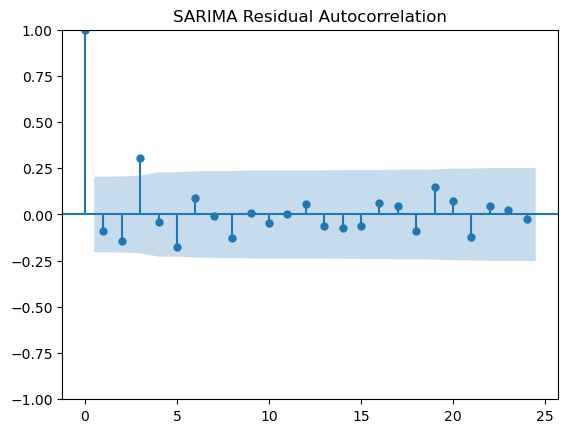

In [30]:
residuals = sarimax_result.resid
plt.figure(figsize=(12,4))
plot_acf(residuals, lags=24, title='SARIMA Residual Autocorrelation')
plt.show()

至少没有明显规律？

Epoch 010 | Train Loss: 0.2061 | Test Loss: 0.2576
Epoch 020 | Train Loss: 0.0346 | Test Loss: 0.2722


C:\Users\Michael Jordan\AppData\Local\Temp\ipykernel_9816\3496191101.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  X_tensor = torch.FloatTensor(X_sequences)


Epoch 030 | Train Loss: 0.0163 | Test Loss: 0.1910
Epoch 040 | Train Loss: 0.0084 | Test Loss: 0.1752
Epoch 050 | Train Loss: 0.0041 | Test Loss: 0.1297


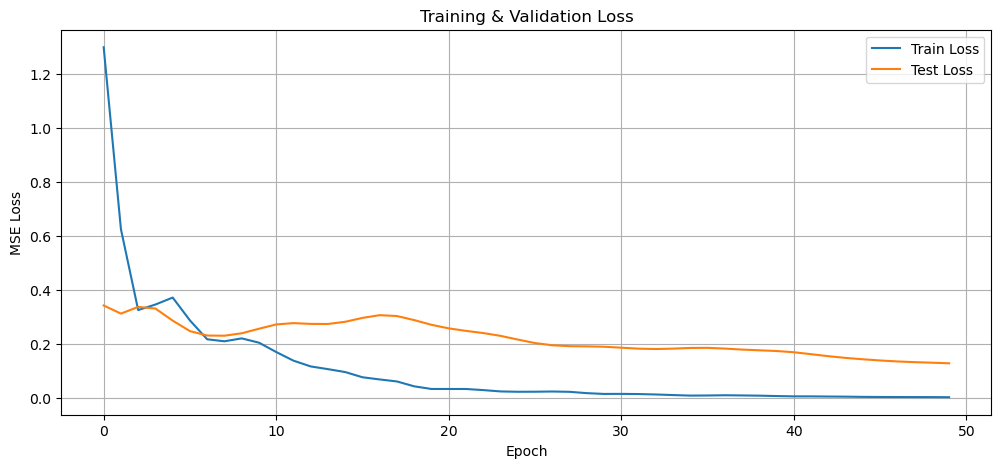

RMSE: 207.69
R² Score: 0.9709
方向准确性DA: 75.7%
MAPE: 11.15%


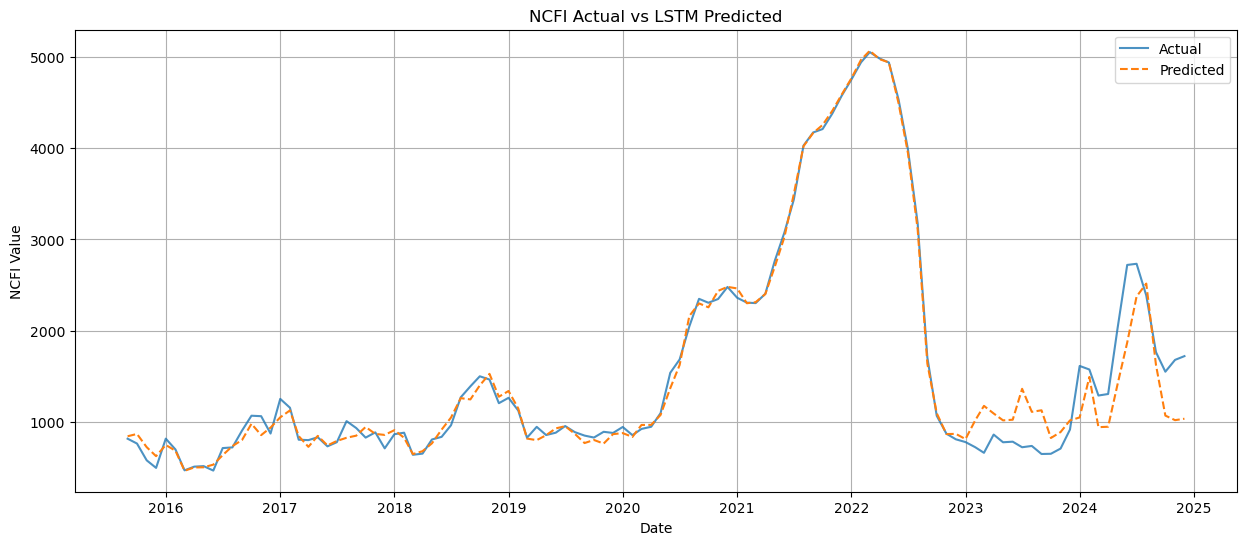

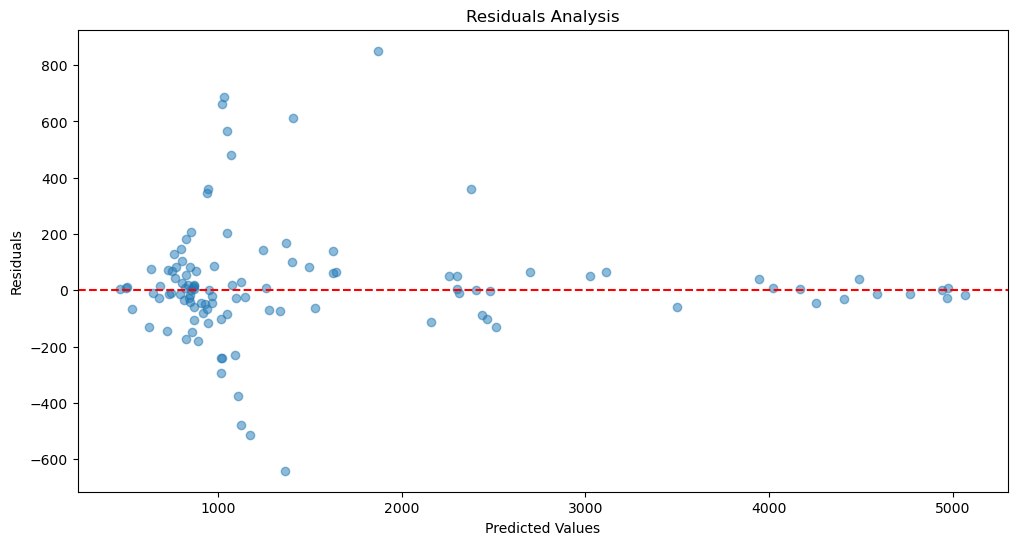

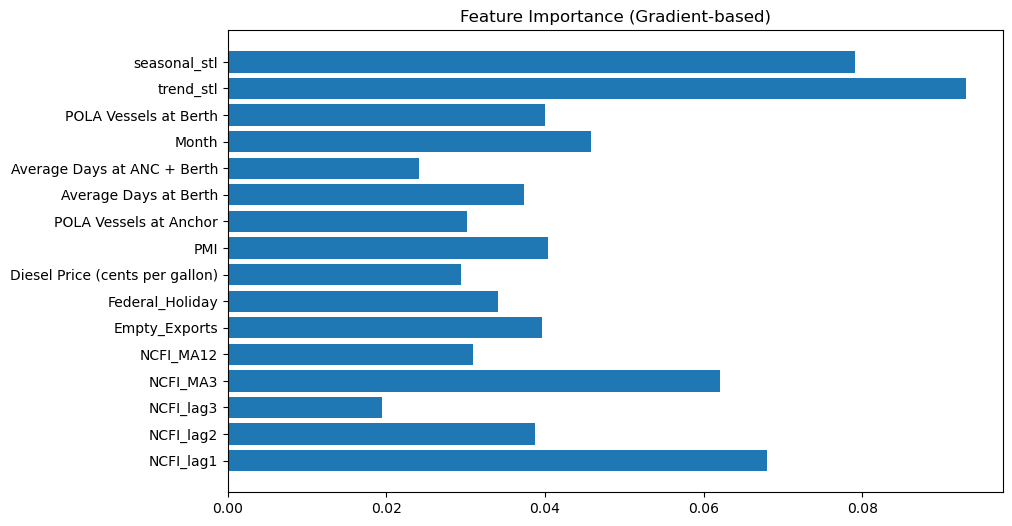

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# --------------------------
# 数据预处理
# --------------------------
def preprocess_data():

    # 定义特征和目标列
    target_col = 'Ningbo Containerized Freight Index, NCFI (West Coast)'
    features = [
        'NCFI_lag1', 'NCFI_lag2', 'NCFI_lag3',
    'NCFI_MA3','NCFI_MA12',
    'Empty_Exports', 'Federal_Holiday' ,
    'Diesel Price (cents per gallon)', 'PMI', 
    'POLA Vessels at Anchor', 
    'Average Days at Berth', 'Average Days at ANC + Berth','Month',
    'POLA Vessels at Berth' , 'trend_stl','seasonal_stl',
    ]

    # 填充缺失值
    merged_data[features] = merged_data[features].fillna(method='ffill')

    # 标准化特征
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(merged_data[features])

    # 标准化目标变量
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(merged_data[[target_col]])

    return X_scaled, y_scaled, scaler_y, merged_data, features, target_col

# --------------------------
# LSTM模型
# --------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=48, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 取最后一个时间步
        return self.linear(out)


# --------------------------
# 模型训练与验证
# --------------------------
def train_model(X_scaled, y_scaled, features):
    # 构建时间序列窗口
    sequence_length = 3
    X_sequences, y_sequences = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])
    
    # 转换为张量
    X_tensor = torch.FloatTensor(X_sequences)
    y_tensor = torch.FloatTensor(y_sequences).view(-1, 1)
    
    # 划分训练测试集
    train_size = int(0.8 * len(X_tensor))
    X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]
    
    # 初始化模型
    model = LSTMModel(input_size=len(features))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    # 训练循环
    train_losses, test_losses = [], []
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        # 验证集评估
        model.eval()
        with torch.no_grad():
            test_preds = model(X_test)
            test_loss = criterion(test_preds, y_test)
        
        # 记录损失
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1:03d} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}')
    
    return model, train_losses, test_losses
# --------------------------
# 结果可视化与评估
# --------------------------
def evaluate_model(model, X_scaled, y_scaled, scaler_y, merged_data, sequence_length):
    # 全量数据预测
    X_tensor = torch.FloatTensor([X_scaled[i:i+sequence_length] for i in range(len(X_scaled)-sequence_length)])
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_tensor).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_scaled[sequence_length:])

    #if 'Date' not in merged_data.columns:  #是index而不是columns
        #print("Warning: 'Date' column not found. Using default index for plotting.")
        #dates = range(len(y_true))
    #else:
        #merged_data['Date'] = pd.to_datetime(merged_data['Date'])
        #dates = merged_data.loc[sequence_length:, 'Date']

    # 确保索引是 datetime 类型
    merged_data.index = pd.to_datetime(merged_data.index)

    # 从索引取时间
    dates = merged_data.index[sequence_length:]

    
    
    # 预测
    X_tensor = torch.FloatTensor([X_scaled[i:i+sequence_length] for i in range(len(X_scaled)-sequence_length)])
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_tensor).numpy()
    
    # 反标准化
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_scaled[sequence_length:])
    
    def directional_accuracy(y_true, y_pred):
        return np.mean((np.diff(y_true.flatten()) * np.diff(y_pred.flatten())) > 0) * 100

    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # 计算 RMSE  R²  DA  MAPE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r2 = r2_score(y_true, y_pred)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'R² Score: {r2:.4f}')  # 输出 R²
    print(f"方向准确性DA: {directional_accuracy(y_true, y_pred):.1f}%")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred):.2f}%")

    # 绘制预测结果
    plt.figure(figsize=(15,6))
    plt.plot(dates, y_true, label='Actual', alpha=0.8)
    plt.plot(dates, y_pred, label='Predicted', linestyle='--')
    plt.title('NCFI Actual vs LSTM Predicted')
    plt.xlabel('Date')
    plt.ylabel('NCFI Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 残差分析
    residuals = y_true - y_pred
    plt.figure(figsize=(12,6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residuals Analysis')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

# --------------------------
# 特征重要性分析
# --------------------------
def feature_importance_analysis(model, X_tensor, features):
    # 基于梯度的重要性
    model.train()
    X_tensor.requires_grad_()
    outputs = model(X_tensor)
    grads = torch.autograd.grad(outputs, X_tensor, grad_outputs=torch.ones_like(outputs))[0]
    grads = grads
    importance = grads.abs().mean(dim=0).mean(dim=0).numpy()
    
    # 可视化
    plt.figure(figsize=(10,6))
    plt.barh(features, importance)
    plt.title('Feature Importance (Gradient-based)')
    plt.show()

# --------------------------
# 主执行流程
# --------------------------
if __name__ == "__main__":
    # 数据预处理
    X_scaled, y_scaled, scaler_y, merged_data, features, target_col = preprocess_data()
    
    # 模型训练
    model, train_losses, test_losses = train_model(X_scaled, y_scaled, features)
    
    # 损失曲线可视化
    plt.figure(figsize=(12,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 模型评估
    sequence_length = 3
    evaluate_model(model, X_scaled, y_scaled, scaler_y, merged_data, sequence_length)
    
    # 特征重要性分析
    X_tensor = torch.FloatTensor([X_scaled[i:i+sequence_length] for i in range(len(X_scaled)-sequence_length)])
    feature_importance_analysis(model, X_tensor, features)

LSTM模型架构和归一化影响了特征重要性得分，不过仍然可以看出来各个特征值的重要性不同，结果也比较符合预期。
<p>调优之后模型的表现还是比较不错的，只是，没有测试集可以参考的时候，我们该如何先选出一个比较不错的模型呢？

感觉还是sarima最强啊，lstm如果也动态选最优可能会很花时间